# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import keras_tuner
from keras_tuner import RandomSearch
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

# Load DataSet

In [2]:
dataset = mnist.load_data()

In [3]:
(x_train,y_train),(x_test,y_test)=dataset

In [4]:
print(f'x_train={len(x_train)}',
      f'x_test={len(x_test)}',
      f'y_train={len(y_train)}',
      f'y_test={len(y_test)}')

x_train=60000 x_test=10000 y_train=60000 y_test=10000


In [5]:
x_train[0].shape

(28, 28)

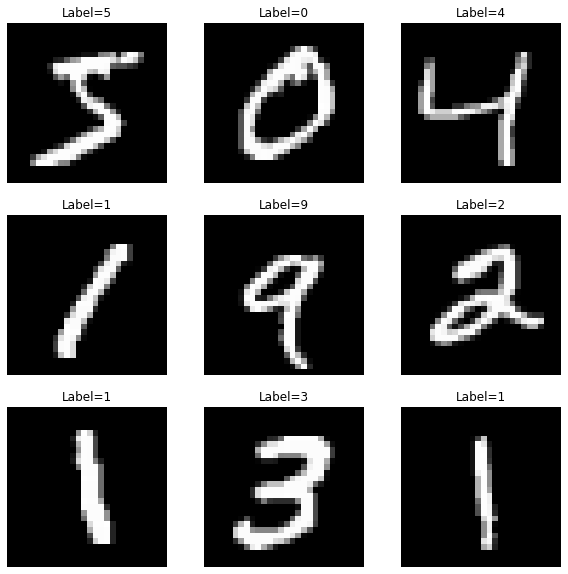

In [7]:
plt.figure(figsize=(10,10))
plt.gray()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title(f"Label={y_train[i]}")
    plt.imshow(x_train[i])
    plt.axis("off")

In [9]:
x_train_scale = x_train/255
x_test_scale=x_test/255
x_train_scale[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
x_train_scale=x_train_scale.reshape((x_train_scale.shape[0],28,28,1))
x_test_scale=x_test_scale.reshape((x_test_scale.shape[0],28,28,1))
y_train_scale=tf.keras.utils.to_categorical(y_train)
y_test_scale=tf.keras.utils.to_categorical(y_test)

In [11]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Create Model

In [12]:
x_train_scale.shape
image_size=28
output=len(np.unique(y_train))
model=tf.keras.Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(output,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 16)                86544     
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 87,034
Trainable params: 87,034
Non-trainable params: 0
____________________________________________________

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train_scale[:1000],y_train_scale[:1000],epochs=10,batch_size=32)

Epoch 1/10
32/32 [==============================] - 2s 22ms/step - loss: 1.8081 - accuracy: 0.3760
Epoch 2/10
32/32 [==============================] - 1s 20ms/step - loss: 0.8998 - accuracy: 0.7710
Epoch 3/10
32/32 [==============================] - 1s 20ms/step - loss: 0.5430 - accuracy: 0.8450
Epoch 4/10
32/32 [==============================] - 1s 19ms/step - loss: 0.3992 - accuracy: 0.8870
Epoch 5/10
32/32 [==============================] - 1s 18ms/step - loss: 0.3152 - accuracy: 0.9130
Epoch 6/10
32/32 [==============================] - 1s 20ms/step - loss: 0.2649 - accuracy: 0.9270
Epoch 7/10
32/32 [==============================] - 1s 22ms/step - loss: 0.2202 - accuracy: 0.9440
Epoch 8/10
32/32 [==============================] - 1s 18ms/step - loss: 0.1972 - accuracy: 0.9520
Epoch 9/10
32/32 [==============================] - 1s 23ms/step - loss: 0.1546 - accuracy: 0.9650
Epoch 10/10
32/32 [==============================] - 1s 27ms/step - loss: 0.1349 - accuracy: 0.9650


In [14]:
model.evaluate(x_test_scale,y_test_scale)

313/313 [==============================] - 3s 7ms/step - loss: 0.3783 - accuracy: 0.8895


[0.37825533747673035, 0.8895000219345093]

# Keras Tuner

In [21]:
def build_model(hp):
    model=tf.keras.Sequential()
    for i in range(hp.Int("Conv Layers",min_value=0,max_value=3)):
        model.add(Conv2D(hp.Choice(f"layer_{i}_filters",[16,32,64]),kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(hp.Choice("Dense layer",[8,16,32]),activation='relu'))
    model.add(Dense(output,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
     directory="./model",
    max_trials=5
)

tuner.search(x_train_scale[:1000],y_train_scale[:1000],
             validation_data=(x_train_scale[2000:3000],y_train_scale[2000:3000]),epochs=10,batch_size=32)

Trial 5 Complete [00h 00m 26s]
val_accuracy: 0.9229999780654907

Best val_accuracy So Far: 0.9419999718666077
Total elapsed time: 00h 02m 04s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_model = tuner.get_best_models()[0]

In [23]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        9280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 32)                247840    
                                                        

In [24]:
best_model.evaluate(x_test_scale,y_test_scale)

313/313 [==============================] - 7s 22ms/step - loss: 0.3588 - accuracy: 0.9230


[0.35880711674690247, 0.9229999780654907]

In [25]:
np.argmax(best_model.predict(np.expand_dims(x_test_scale[0],axis=0)))

1/1 [==============================] - 0s 207ms/step


7

1/1 [==============================] - 0s 40ms/step


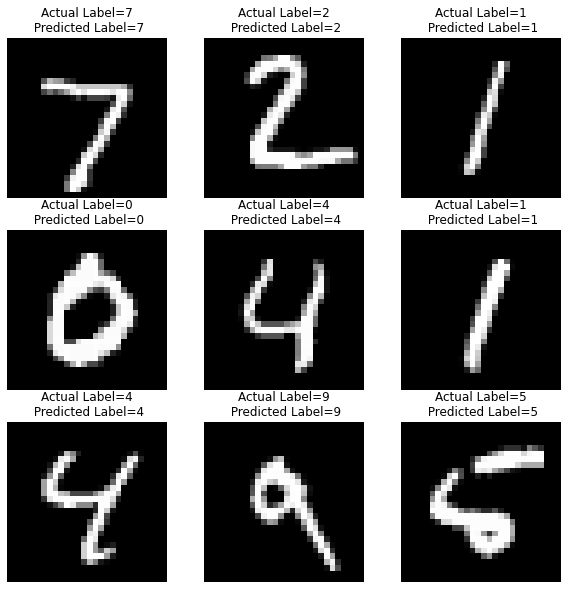

In [26]:
plt.figure(figsize=(10,10))
plt.gray()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title(f"Actual Label={y_test[i]}\n Predicted Label={np.argmax(best_model.predict(np.expand_dims(x_test_scale[i],axis=0)))}")
    plt.imshow(x_test_scale[i])
    plt.axis("off")